In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

2025-04-19 09:26:35.480326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 09:26:35.781761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745054795.913373   21210 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745054795.946737   21210 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 09:26:36.173095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
base_dir = "/home/sanjai/mlprojects/Unisys/data"
metadata_file = os.path.join(base_dir, "UrbanSound8K.csv")

In [3]:
n_mels = 128
n_fft = 2048
hop_length = 512
time_frames = 128

In [4]:
audiofiles = pd.read_csv(metadata_file)
print(f"Total entries: {len(audiofiles)}")

Total entries: 5892


In [5]:
def extract_enhanced_mel(file_path, n_mels, n_fft, hop_length, time_frames):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Apply pre-emphasis filter to boost high frequencies
        y = librosa.effects.preemphasis(y)
        
        # Trim silence from the beginning and end
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # Extract mel spectrogram with optimized parameters
        mel = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,
            fmax=sr/2  # Use maximum frequency
        )
        
        # Convert to dB with better scaling
        mel_db = librosa.power_to_db(mel, ref=np.max, top_db=80)
        
        # Pad or trim to target length
        if mel_db.shape[1] > time_frames:
            mel_db = mel_db[:, :time_frames]
        elif mel_db.shape[1] < time_frames:
            pad_width = time_frames - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        
        # Convert to RGB by duplicating across 3 channels
        mel_rgb = np.stack([mel_db, mel_db, mel_db], axis=-1)
        
        return mel_rgb
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [6]:
X_data = []
y_data = []

In [7]:
for i in range(len(audiofiles)):
    if i % 100 == 0:
        print(f"Processing {i}/{len(audiofiles)}")

    row = audiofiles.iloc[i]
    file_path = os.path.join(base_dir, f"fold{row['fold']}", row['slice_file_name'])

    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        continue

    mel_rgb = extract_enhanced_mel(file_path, n_mels, n_fft, hop_length, time_frames)
    if mel_rgb is not None:
        X_data.append(mel_rgb)
        y_data.append(row['classID'])

Processing 0/5892
Processing 100/5892
Processing 200/5892
Processing 300/5892
Processing 400/5892
Processing 500/5892
Processing 600/5892
Processing 700/5892
Processing 800/5892
Processing 900/5892
Processing 1000/5892
Processing 1100/5892
Processing 1200/5892
Processing 1300/5892
Processing 1400/5892
Processing 1500/5892
Processing 1600/5892
Processing 1700/5892
Processing 1800/5892
Processing 1900/5892


/home/sanjai/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 2000/5892
Processing 2100/5892
Processing 2200/5892
Processing 2300/5892
Processing 2400/5892
Processing 2500/5892
Processing 2600/5892
Processing 2700/5892
Processing 2800/5892
Processing 2900/5892
Processing 3000/5892
Processing 3100/5892
Processing 3200/5892
Processing 3300/5892
Processing 3400/5892
Processing 3500/5892
Processing 3600/5892
Processing 3700/5892
Processing 3800/5892
Processing 3900/5892
Processing 4000/5892
Processing 4100/5892
Processing 4200/5892
Processing 4300/5892
Processing 4400/5892
Processing 4500/5892
Processing 4600/5892
Processing 4700/5892
Processing 4800/5892
Processing 4900/5892
Processing 5000/5892
Processing 5100/5892
Processing 5200/5892
Processing 5300/5892
Processing 5400/5892
Processing 5500/5892
Processing 5600/5892
Processing 5700/5892
Processing 5800/5892


In [8]:
X_data = np.array(X_data)
y_data = np.array(y_data)
print(f"X_data shape: {X_data.shape}")

X_data shape: (5892, 128, 128, 3)


In [9]:
X_data = (X_data - np.mean(X_data, axis=0)) / (np.std(X_data, axis=0) + 1e-10)

In [10]:
y_categorical = to_categorical(y_data)
num_classes = y_categorical.shape[1]
print(f"Number of classes: {num_classes}")

Number of classes: 14


In [11]:
data_augmentation = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    rotation_range=5,  # Small rotation is usually fine for spectrograms
    fill_mode='constant'
)

In [12]:
def mixup_data(x, y, alpha=0.2):
    batch_size = len(x)
    weights = np.random.beta(alpha, alpha, batch_size)
    indices = np.random.permutation(batch_size)
    
    x_weights = weights.reshape(batch_size, 1, 1, 1)
    y_weights = weights.reshape(batch_size, 1)
    
    x_mix = x * x_weights + x[indices] * (1 - x_weights)
    y_mix = y * y_weights + y[indices] * (1 - y_weights)
    return x_mix, y_mix

In [13]:
def create_model(input_shape, num_classes, lr=0.001):
    # Create a hybrid model using ResNet50 and EfficientNetB0
    # ResNet50 branch
    resnet_input = Input(shape=input_shape)
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_tensor=resnet_input)
    
    # Freeze early layers (only train the last 30 layers)
    for layer in resnet_base.layers[:-30]:
        layer.trainable = False
    
    resnet_output = GlobalAveragePooling2D()(resnet_base.output)
    
    # Dense layers for classification
    x = Dense(512, activation='relu')(resnet_output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=resnet_input, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [14]:
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.5
    return lr

In [15]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [16]:
fold_histories = []
fold_scores = []

In [17]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
    print(f"\nTraining fold {fold+1}/{n_splits}")
    
    # Get fold data
    X_train_fold, X_val_fold = X_data[train_idx], X_data[val_idx]
    y_train_fold, y_val_fold = y_categorical[train_idx], y_categorical[val_idx]
    
    # Create the model
    model = create_model(input_shape=X_train_fold.shape[1:], num_classes=num_classes)
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ModelCheckpoint(f'best_model_fold_{fold+1}.keras', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]


Training fold 1/5


I0000 00:00:1745055147.884601   21210 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



Training fold 2/5

Training fold 3/5

Training fold 4/5

Training fold 5/5


In [18]:
train_generator = data_augmentation.flow(X_train_fold, y_train_fold,batch_size=32)

In [19]:
epochs = 50
batch_size = 32
steps_per_epoch = len(X_train_fold) // batch_size

In [20]:
print("Initial training with frozen layers...")

history_initial = model.fit(train_generator,validation_data=(X_val_fold, y_val_fold),epochs=20,steps_per_epoch=steps_per_epoch,callbacks=callbacks,verbose=1)

Initial training with frozen layers...
Epoch 1/20


/home/sanjai/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745055161.756848   21506 service.cc:148] XLA service 0x7fa720004110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745055161.757296   21506 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-19 09:32:41.953723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745055163.001052   21506 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-19 09:32:46.979330: I externa

  2/147 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.0625 - loss: 3.7730 

I0000 00:00:1745055173.996833   21506 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 58/147 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.3261 - loss: 2.4566

2025-04-19 09:32:59.240806: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6775_0', 8 bytes spill stores, 8 bytes spill loads



147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4069 - loss: 2.0717 

2025-04-19 09:33:13.493493: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1734_0', 8 bytes spill stores, 8 bytes spill loads

2025-04-19 09:33:13.774722: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1734', 132 bytes spill stores, 132 bytes spill loads



147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.4075 - loss: 2.0690 - val_accuracy: 0.3701 - val_loss: 3.7757 - learning_rate: 0.0010
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.5312 - loss: 1.7976

/home/sanjai/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5312 - loss: 1.7976 - val_accuracy: 0.4134 - val_loss: 3.0336 - learning_rate: 0.0010
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.5884 - loss: 1.2816 - val_accuracy: 0.5348 - val_loss: 1.7615 - learning_rate: 0.0010
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5312 - loss: 1.2877 - val_accuracy: 0.5424 - val_loss: 1.5185 - learning_rate: 0.0010
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.6438 - loss: 1.0500 - val_accuracy: 0.4482 - val_loss: 2.5276 - learning_rate: 0.0010
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7500 - loss: 0.9490 - val_accuracy: 0.4677 - val_loss: 2.5314 - learning_rate: 0.0010
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6895 - loss: 0.9200 - val_accuracy: 0.6027 - val_loss: 1.1614 - learning_rate: 0.0010
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5312 - loss: 2.0894 - val

In [24]:
print("Fine-tuning with unfrozen layers...")
# Unfreeze layers for fine-tuning
# Find the ResNet base model inside your model architecture
resnet_base = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model):  # This detects the ResNet base model
        resnet_base = layer
        break

# If ResNet base is found, unfreeze its layers
if resnet_base:
    # Unfreeze only the last 30 layers of ResNet
    for layer in resnet_base.layers[-30:]:
        layer.trainable = True
else:
    # Alternative approach if the above doesn't work
    # Just unfreeze all layers in the main model
    for layer in model.layers:
        layer.trainable = True

Fine-tuning with unfrozen layers...


In [25]:
 model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
history_fine_tuning = model.fit(train_generator,validation_data=(X_val_fold, y_val_fold),epochs=30,initial_epoch=20,steps_per_epoch=steps_per_epoch,callbacks=callbacks,verbose=1)

Epoch 21/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 57s 195ms/step - accuracy: 0.8368 - loss: 0.4811 - val_accuracy: 0.8362 - val_loss: 0.4995 - learning_rate: 1.0000e-05
Epoch 22/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8750 - loss: 0.4427 - val_accuracy: 0.8336 - val_loss: 0.4991 - learning_rate: 1.0000e-05
Epoch 23/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8334 - loss: 0.5001 - val_accuracy: 0.8370 - val_loss: 0.4456 - learning_rate: 1.0000e-05
Epoch 24/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9062 - loss: 0.4528 - val_accuracy: 0.8370 - val_loss: 0.4448 - learning_rate: 1.0000e-05
Epoch 25/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.8748 - loss: 0.4038 - val_accuracy: 0.8557 - val_loss: 0.4101 - learning_rate: 1.0000e-05
Epoch 26/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9375 - loss: 0.2500 - val_accuracy: 0.8557 - val_loss: 0.4104 - learning_rate: 1.0000e-05
Epoch 27/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/

In [27]:
val_score = model.evaluate(X_val_fold, y_val_fold)
print(f"Fold {fold+1} validation accuracy: {val_score[1]:.4f}")
    
fold_scores.append(val_score[1])

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9094 - loss: 0.2893 
Fold 5 validation accuracy: 0.9015


In [28]:
model.save(f'resnet_model{fold+1}.keras')

In [29]:
print("\nCross-validation results:")
for i, score in enumerate(fold_scores):
    print(f"Fold {i+1}: {score:.4f}")
print(f"Average accuracy: {np.mean(fold_scores):.4f}")
print(f"Standard deviation: {np.std(fold_scores):.4f}")


Cross-validation results:
Fold 1: 0.9015
Average accuracy: 0.9015
Standard deviation: 0.0000


In [30]:
model.save(f'resnet_model{fold+1}.keras')

In [47]:
model.save(f'saved_model/resnet_model_fold{fold+1}.keras')

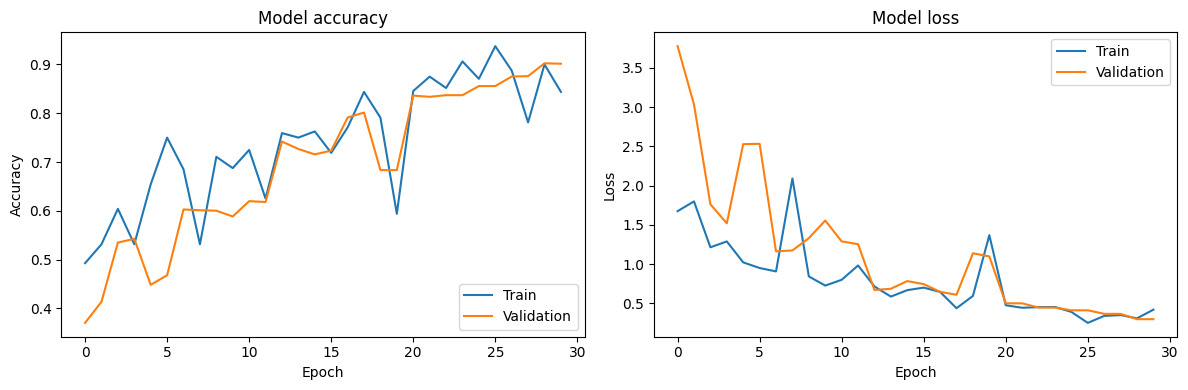

In [48]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['accuracy'] + history_fine_tuning.history['accuracy'])
plt.plot(history_initial.history['val_accuracy'] + history_fine_tuning.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_initial.history['loss'] + history_fine_tuning.history['loss'])
plt.plot(history_initial.history['val_loss'] + history_fine_tuning.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [49]:
audiofiles.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
2,100648-1-1-0.wav,100648,8.998279,10.052132,2,10,1,car_horn
3,100648-1-2-0.wav,100648,16.699509,17.104837,2,10,1,car_horn
4,100648-1-3-0.wav,100648,17.631764,19.253075,2,10,1,car_horn


In [50]:
audiofiles.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
5887,weapon_gun_rattle_out_36.wav,156,0.0,3.0,1,11,13,weapon_clink
5888,weapon_gun_rattle_out_37.wav,157,0.0,2.0,1,11,13,weapon_clink
5889,weapon_gun_rattle_out_38.wav,158,0.0,2.0,1,11,13,weapon_clink
5890,weapon_gun_rattle_out_39.wav,159,0.0,3.0,1,11,13,weapon_clink
5891,weapon_gun_rattle_out_40.wav,160,0.0,2.0,1,11,13,weapon_clink


In [51]:
audiofiles['class'].unique()

array(['dog_bark', 'car_horn', 'gun_shot', 'siren', 'engine_idling',
       'jackhammer', 'drilling', 'chainsaw', 'footsteps',
       'radio_human_sound', 'weapon_clink'], dtype=object)

In [52]:
class_names = ['dog_bark', 'car_horn', 'gun_shot', 'siren', 'engine_idling',
       'jackhammer', 'drilling', 'chainsaw', 'footsteps',
       'radio_human_sound', 'weapon_clink']

In [53]:
n_mels = 128
n_fft = 2048
hop_length = 512
time_frames = 128

In [75]:
def preprocess_audio(audio_path):
    print(f"Processing file: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    print(f"Audio loaded: duration={len(y)/sr:.2f}s, sample rate={sr}Hz")
    
    # Apply pre-emphasis filter to boost high frequencies
    y = librosa.effects.preemphasis(y)
    
    # Trim silence from the beginning and end
    y, _ = librosa.effects.trim(y, top_db=20)
    
    # Extract mel spectrogram
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,
        fmax=sr/2
    )
    
    # Convert to dB scale
    mel_db = librosa.power_to_db(mel, ref=np.max, top_db=80)
    
    # Pad or trim to target length
    if mel_db.shape[1] > time_frames:
        mel_db = mel_db[:, :time_frames]
    elif mel_db.shape[1] < time_frames:
        pad_width = time_frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    
    # Convert to RGB by replicating the spectrogram across 3 channels
    mel_rgb = np.stack([mel_db, mel_db, mel_db], axis=-1)
    
    # Normalize (use same normalization as during training)
    mel_rgb = (mel_rgb - np.mean(mel_rgb)) / (np.std(mel_rgb) + 1e-10)
    
    return mel_rgb, mel_db, y, sr  # Changed 's' to 'sr'

In [76]:
def predict_audio_class(model, audio_path):
    # Preprocess the audio
    mel_rgb, mel_db, y, sr = preprocess_audio(audio_path)
    
    # Add batch dimension
    mel_rgb = np.expand_dims(mel_rgb, axis=0)
    
    # Make prediction
    prediction = model.predict(mel_rgb)
    
    # Get the predicted class
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence, mel_db, y, sr, prediction[0]

In [81]:
def visualize_prediction(audio_path, predicted_class, confidence, mel_db, y, sr, all_probabilities):
    plt.figure(figsize=(15, 10))
    
    # Plot waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Plot mel spectrogram
    plt.subplot(3, 1, 2)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    
    # Plot prediction probabilities - THIS IS WHERE THE CHANGE IS NEEDED
    plt.subplot(3, 1, 3)
    plt.bar(range(len(all_probabilities)), all_probabilities)
    
    # FIX: Make sure the number of tick locations matches the number of labels
    # Option 1: Use generic class labels
    plt.xticks(range(len(all_probabilities)), [f"Class {i}" for i in range(len(all_probabilities))], rotation=45)
    
    # Option 2 (alternative): Truncate to match class_names length
    # plt.xticks(range(len(class_names)), class_names, rotation=45)
    
    plt.xlabel('Class')
    plt.ylabel('Probability')
    
    # Ensure predicted_class is within the range of class_names
    if 0 <= predicted_class < len(class_names):
        predicted_class_name = class_names[predicted_class]
    else:
        predicted_class_name = f"Unknown (Class {predicted_class})"
        
    plt.title(f'Prediction: {predicted_class_name} (Confidence: {confidence:.2f})')
    
    plt.tight_layout()
    plt.savefig(f'prediction_{os.path.basename(audio_path)}.png')
    plt.show()
    
    return predicted_class_name

In [82]:
def analyze_audio(model_path, audio_path):
    # Load the model
    model = load_model(model_path)
    print(f"Model loaded from {model_path}")
    
    # Predict
    predicted_class, confidence, mel_db, y, sr, all_probabilities = predict_audio_class(model, audio_path)
    
    # Visualize
    predicted_class_name = visualize_prediction(audio_path, predicted_class, confidence, mel_db, y, sr, all_probabilities)
    
    # Print results
    print(f"\nAudio file: {os.path.basename(audio_path)}")
    print(f"Predicted class: {predicted_class_name}")
    print(f"Confidence: {confidence:.2f}")
    
    # Print top 3 predictions
    top_3_indices = np.argsort(all_probabilities)[-3:][::-1]
    print("\nTop 3 predictions:")
    for i, idx in enumerate(top_3_indices):
        print(f"{i+1}. {class_names[idx]}: {all_probabilities[idx]:.4f}")    

In [83]:
import os
from tensorflow.keras.models import load_model

def batch_process_audio_files(model_path, audio_dir):
    # Load the model
    model = load_model(model_path)
    print(f"Model loaded from {model_path}")
    
    # Get all audio files
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith(('.wav', '.mp3', '.ogg'))]
    
    results = []
    
    for audio_file in audio_files:
        audio_path = os.path.join(audio_dir, audio_file)
        predicted_class, confidence, _, _, _, all_probabilities = predict_audio_class(model, audio_path)
        
        predicted_class_name = class_names[predicted_class]
        
        results.append({
            'file': audio_file,
            'predicted_class': predicted_class_name,
            'confidence': confidence
        })
        
        print(f"File: {audio_file}, Predicted: {predicted_class_name}, Confidence: {confidence:.2f}")
    
    return results

Model loaded from saved_model/resnet_model_fold5.keras
Processing file: /home/sanjai/mlprojects/Unisys/data/fold5/178260-7-3-3.wav
Audio loaded: duration=4.00s, sample rate=48000Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


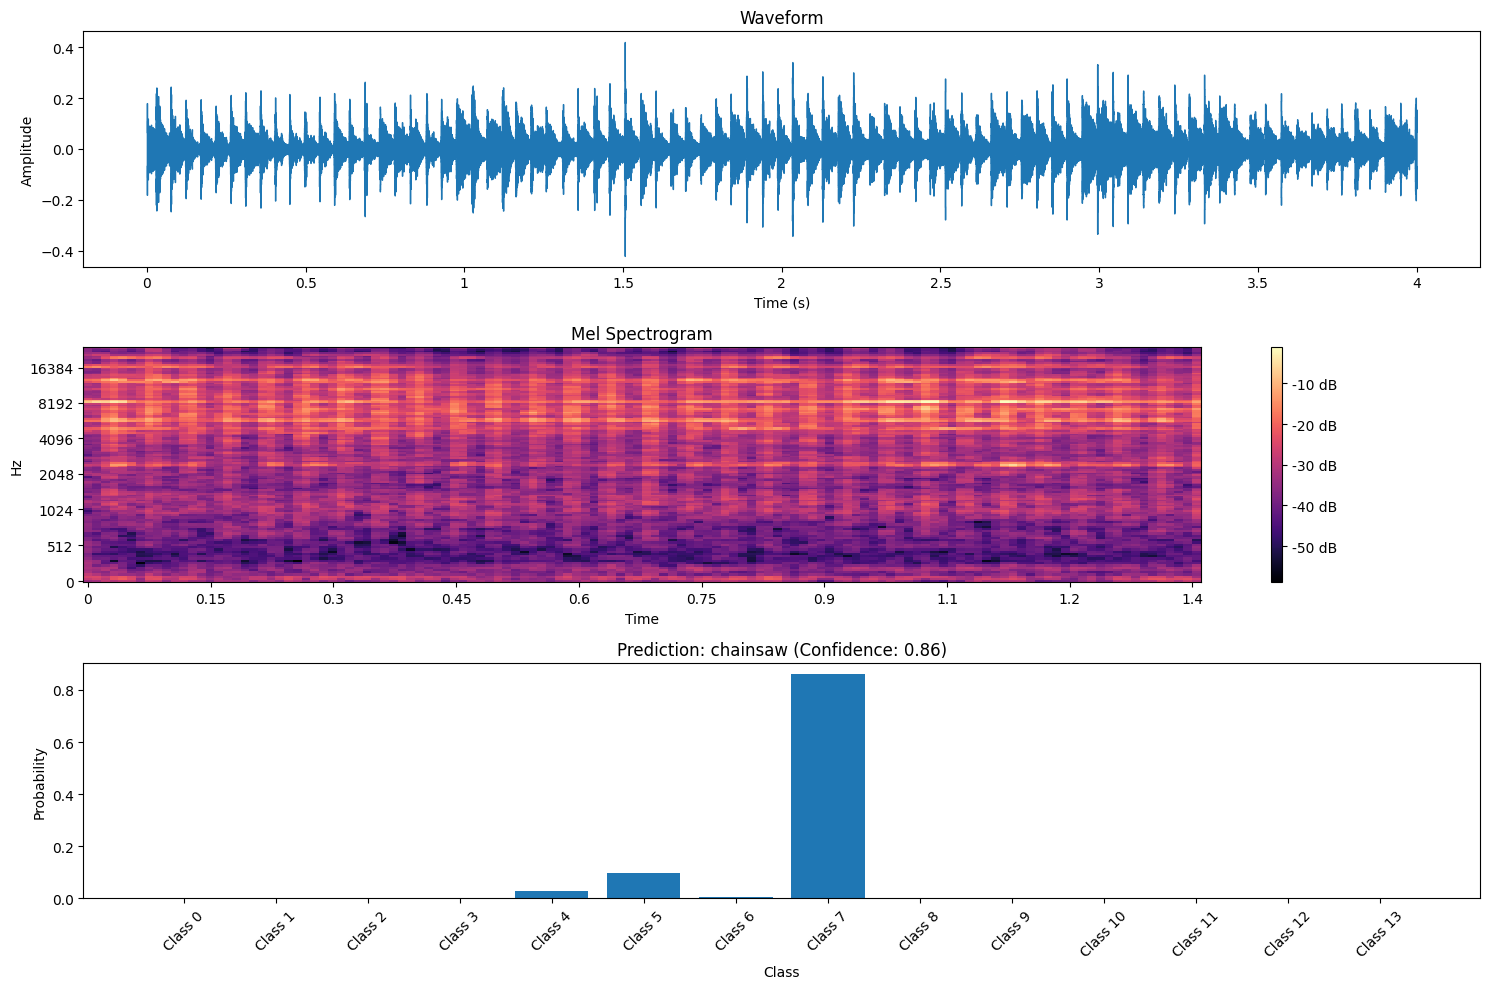


Audio file: 178260-7-3-3.wav
Predicted class: chainsaw
Confidence: 0.86

Top 3 predictions:
1. chainsaw: 0.8600
2. jackhammer: 0.0959
3. engine_idling: 0.0280


In [88]:
if __name__ == "__main__":
    # Update these paths
    model_path = "saved_model/resnet_model_fold5.keras"
    audio_path = "/home/sanjai/mlprojects/Unisys/data/fold5/178260-7-3-3.wav"  # Single audio file

    # For single file analysis
    analyze_audio(model_path, audio_path)

In [87]:
from IPython.display import Audio

# Path to your audio file
audio_path = "/home/sanjai/mlprojects/Unisys/data/fold5/178260-7-3-3.wav"

# Play the audio
Audio(filename=audio_path)